Loading test data from: /content/drive/MyDrive/ecg/202.csv
  → Extracted 1811 test segments.

Loading training data from: /content/drive/MyDrive/ecg/yo10.csv
Loaded training data: (47, 3)
Columns: ['Person_ID', 'MLII_segment', 'V1_segment']
  → Training data shape: (33741, 400)
  → Number of unique persons: 47

Training system...
Splitting data for validation...
Training Autoencoder...
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 183s 419ms/step - loss: 0.0164 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 175s 415ms/step - loss: 0.0029 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 202s 479ms/step - loss: 0.0023 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 175s 415ms/step - loss: 0.0018 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 202s 478ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 235s 415ms/step - loss: 0.0015 - learning_rate: 0.0010
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 2

KeyError: 'val_loss'

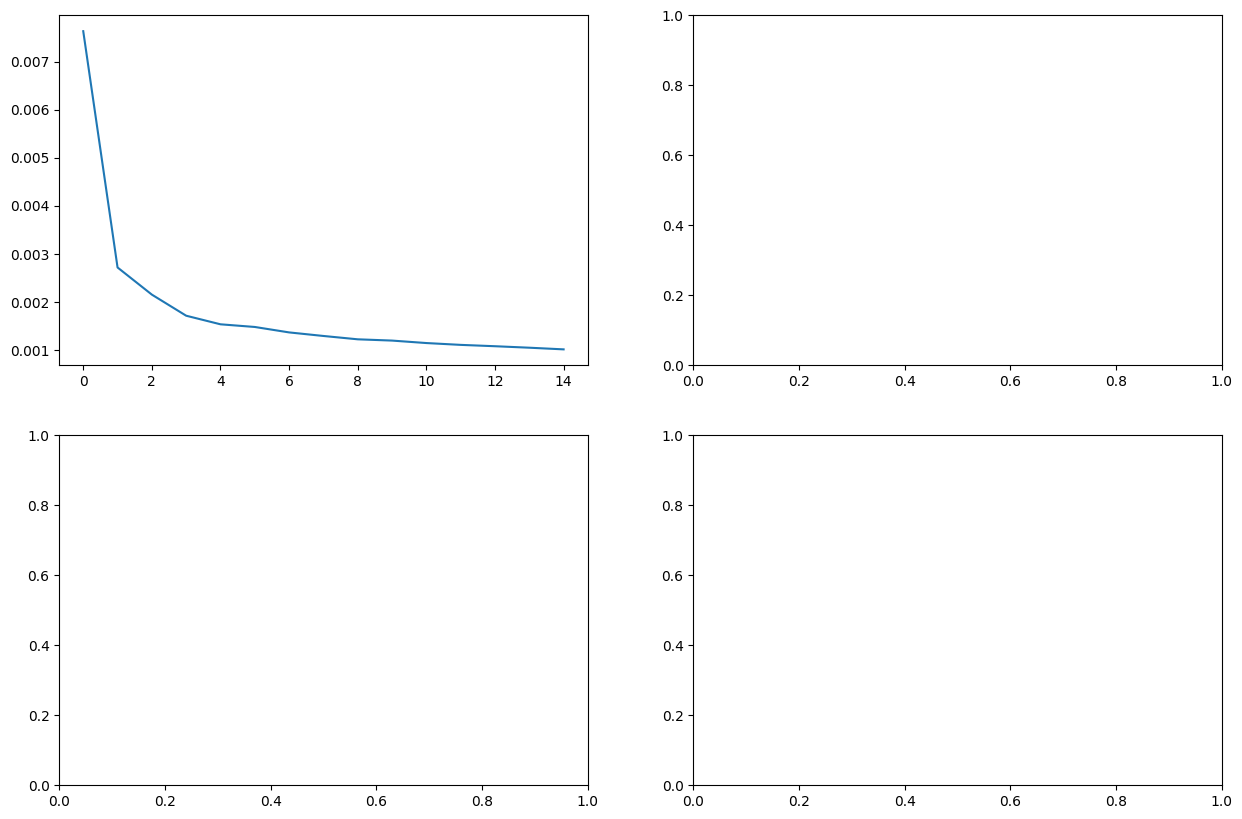

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import signal
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class ECGPreprocessor:
    """ECG signal preprocessing including filtering, R-peak detection, and segmentation"""

    def __init__(self, fs=500):
        self.fs = fs  # Sampling frequency

    def apply_bandpass_filter(self, ecg_signal, lowcut=0.7, highcut=90):
        """Apply bandpass filter to remove noise"""
        nyquist = self.fs / 2
        low = lowcut / nyquist
        high = highcut / nyquist

        # Design Butterworth bandpass filter
        b, a = signal.butter(4, [low, high], btype='band')
        filtered_signal = signal.filtfilt(b, a, ecg_signal)

        # Notch filter for 50Hz power line interference
        notch_freq = 50.0
        quality_factor = 30.0
        b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, self.fs)
        filtered_signal = signal.filtfilt(b_notch, a_notch, filtered_signal)

        return filtered_signal

    def detect_r_peaks(self, ecg_signal):
        """Detect R-peaks in ECG signal"""
        # Simple R-peak detection using find_peaks
        # Normalize signal
        normalized_signal = (ecg_signal - np.mean(ecg_signal)) / np.std(ecg_signal)

        # Find peaks with minimum distance and height
        min_distance = int(0.4 * self.fs)  # Minimum 0.4s between R-peaks
        peaks, _ = find_peaks(normalized_signal, distance=min_distance, height=0.5)

        return peaks

    def segment_heartbeats(self, ecg_signal, r_peaks, before_samples=160, after_samples=240):
        """
        Extract heartbeat segments centered around R-peaks
        before_samples: 0.32s * 500Hz = 160 samples
        after_samples: 0.48s * 500Hz = 240 samples
        """
        segments = []

        for r_peak in r_peaks[1:-1]:  # Exclude first and last R-peaks
            start_idx = r_peak - before_samples
            end_idx = r_peak + after_samples

            if start_idx >= 0 and end_idx < len(ecg_signal):
                segment = ecg_signal[start_idx:end_idx]
                if len(segment) == (before_samples + after_samples):
                    segments.append(segment)

        return np.array(segments)

    def normalize_amplitude(self, segments, target_amplitude=2.0):
        """Normalize segment amplitudes to 2mV"""
        normalized_segments = []

        for segment in segments:
            current_amplitude = np.max(segment) - np.min(segment)
            if current_amplitude > 0:
                normalized_segment = segment * (target_amplitude / current_amplitude)
                normalized_segments.append(normalized_segment)

        return np.array(normalized_segments)

    def generate_template(self, segments):
        """Generate template from ECG segments"""
        if len(segments) < 5:
            return np.mean(segments, axis=0)

        # Compute element-wise average
        avg_segment = np.mean(segments, axis=0)

        # Find 5 segments with smallest Euclidean distance from average
        distances = [np.linalg.norm(segment - avg_segment) for segment in segments]
        closest_indices = np.argsort(distances)[:5]

        # Average the 5 closest segments
        template = np.mean(segments[closest_indices], axis=0)

        return template

    def generate_summary_segments(self, segments, block_size=10):
        """Generate summary segments from blocks of consecutive segments"""
        summary_segments = []

        for i in range(0, len(segments) - block_size + 1, block_size):
            block = segments[i:i + block_size]
            if len(block) == block_size:
                summary_segment = self.generate_template(block)
                summary_segments.append(summary_segment)

        return np.array(summary_segments)

class ECGAutoencoder:
    """Autoencoder for ECG feature extraction"""

    def __init__(self, input_length=400):
        self.input_length = input_length
        self.model = None
        self.encoder = None
        self.history = None

    def build_model(self):
        """Build autoencoder architecture"""
        # Input layer
        input_layer = layers.Input(shape=(self.input_length, 1))

        # Encoder
        x = layers.Conv1D(32, 5, activation='relu', padding='same')(input_layer)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)

        x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)

        x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)

        x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2)(x)

        # Feature extraction layer (2 channels, 25 features each)
        encoded = layers.Conv1D(2, 3, activation='relu', padding='same')(x)

        # Decoder
        x = layers.Conv1D(256, 3, activation='relu', padding='same')(encoded)
        x = layers.UpSampling1D(2)(x)

        x = layers.Conv1D(128, 5, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)

        x = layers.Conv1D(64, 5, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)

        x = layers.Conv1D(32, 5, activation='relu', padding='same')(x)
        x = layers.UpSampling1D(2)(x)

        # Output layer
        decoded = layers.Conv1D(1, 5, activation='linear', padding='same')(x)

        # Create models
        self.model = Model(input_layer, decoded)
        self.encoder = Model(input_layer, encoded)

        # Compile
        self.model.compile(optimizer='adam', loss='mse')

        return self.model

    def train(self, X_train, epochs=15, batch_size=64, validation_split=0.2):
        """Train the autoencoder with tf.data pipeline"""
        if self.model is None:
            self.build_model()

        # 1) Define callbacks here
        early_stopping = EarlyStopping(
        monitor='val_loss',      # make sure you’re watching validation!
        patience=10,
        restore_best_weights=True
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',factor=0.2,patience=3)

        # 2) Prepare data
        Xr = X_train.reshape(-1, self.input_length, 1)
        dataset = tf.data.Dataset.from_tensor_slices((Xr, Xr))
        dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        # 3) Split train/val
        val_size = int((1 - validation_split) * len(Xr))
        train_ds = dataset.take(val_size)
        val_ds   = dataset.skip(val_size)

        # 4) Fit with callbacks
        self.history = self.model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )
        return self.history

    def extract_features(self, segments):
        """Extract features using trained encoder"""
        if self.encoder is None:
            raise ValueError("Model must be trained first")

        segments_reshaped = segments.reshape(-1, self.input_length, 1)
        features = self.encoder.predict(segments_reshaped)

        # Flatten features (25 x 2 = 50 features per segment)
        features_flattened = features.reshape(features.shape[0], -1)

        return features_flattened

class SiameseCNN:
    """Siamese CNN for ECG biometric verification and identification"""

    def __init__(self, feature_dim=50, num_classes=47):
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        self.model = None
        self.identification_model = None
        self.history = None

    def create_base_network(self):
        """Create base network for Siamese architecture"""
        input_layer = layers.Input(shape=(self.feature_dim,))

        x = layers.Dense(512, activation='relu')(input_layer)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        output = layers.Dense(1024, activation='relu')(x)

        return Model(input_layer, output)

    def build_siamese_model(self):
        """Build Siamese CNN model"""
        # Create base network
        base_network = self.create_base_network()

        # Input pairs
        input_a = layers.Input(shape=(self.feature_dim,))
        input_b = layers.Input(shape=(self.feature_dim,))

        # Generate features for both inputs
        processed_a = base_network(input_a)
        processed_b = base_network(input_b)

        # Calculate Euclidean distance
        distance = layers.Lambda(
            lambda x: tf.abs(x[0] - x[1])
        )([processed_a, processed_b])

        # Classification layer
        output = layers.Dense(1, activation='sigmoid')(distance)

        self.model = Model([input_a, input_b], output)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return self.model

    def build_identification_model(self):
        """Build model for identification task"""
        base_network = self.create_base_network()

        input_layer = layers.Input(shape=(self.feature_dim,))
        features = base_network(input_layer)

        # Classification layer for identification
        output = layers.Dense(self.num_classes, activation='softmax')(features)

        self.identification_model = Model(input_layer, output)
        self.identification_model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return self.identification_model

class ECGBiometricSystem:
    """Complete ECG Biometric Identification System with Enhanced Evaluation"""

    def __init__(self):
        self.preprocessor = ECGPreprocessor()
        self.autoencoder = ECGAutoencoder()
        self.siamese_cnn = SiameseCNN()
        self.templates = {}
        self.person_ids = []
        self.label_to_person_id = {}
        self.person_id_to_label = {}
        self.evaluation_results = {}

    def load_training_data(self, file_path):
        """Load training data from yo10.csv"""
        try:
            # Load data
            df = pd.read_csv(file_path)
            print(f"Loaded training data: {df.shape}")
            print(f"Columns: {df.columns.tolist()}")

            # Extract unique person IDs and create mappings
            unique_person_ids = df['Person_ID'].unique()
            self.person_ids = list(unique_person_ids)

            # Create label mappings
            for idx, person_id in enumerate(unique_person_ids):
                self.label_to_person_id[idx] = person_id
                self.person_id_to_label[person_id] = idx

            # Process each person's data
            all_segments = []
            all_labels = []

            for idx, row in df.iterrows():
                person_id = row['Person_ID']

                # Extract MLII signal
                mlii_signal = self._parse_signal_array(row['MLII_segment'])

                if len(mlii_signal) > 0:
                    # Preprocess signal
                    filtered_signal = self.preprocessor.apply_bandpass_filter(mlii_signal)
                    r_peaks = self.preprocessor.detect_r_peaks(filtered_signal)
                    segments = self.preprocessor.segment_heartbeats(filtered_signal, r_peaks)

                    if len(segments) > 0:
                        normalized_segments = self.preprocessor.normalize_amplitude(segments)

                        # Generate template for this person
                        template = self.preprocessor.generate_template(normalized_segments)
                        self.templates[person_id] = template

                        # Add segments to training data
                        person_label = self.person_id_to_label[person_id]
                        all_segments.extend(normalized_segments)
                        all_labels.extend([person_label] * len(normalized_segments))

            return np.array(all_segments), np.array(all_labels)

        except Exception as e:
            print(f"Error loading training data: {e}")
            return None, None

    def load_test_data(self, path):
      """Load and preprocess a single-test ECG file.Returns:segments (np.ndarray): heartbeat segments from the MLII lead."""
      # 1) Read CSV
      df = pd.read_csv(path)
      # 2) Clean column names
      clean_cols = {c: c.strip("'\" ") for c in df.columns}
      df = df.rename(columns=clean_cols)
      # 3) Find the MLII column
      mlii_cols = [c for c in df.columns if 'mlii' in c.lower()]
      if not mlii_cols:
        raise KeyError(f"No MLII-like column found. Available: {df.columns.tolist()}")
      col = mlii_cols[0]
      # 4) Extract a raw signal array
      first = df[col].iloc[0]
      if isinstance(first, str) and first.strip().startswith('['):
        # legacy: one big bracketed string in row 0
        raw = self._parse_signal_array(first)
      else:
          # modern: one numeric sample per row
        raw = df[col].to_numpy(dtype=float)
        if raw.size == 0:
          raise ValueError("Parsed test ECG signal is empty.")
      # 5) Preprocess exactly as in training
      filtered  = self.preprocessor.apply_bandpass_filter(raw)
      peaks     = self.preprocessor.detect_r_peaks(filtered)
      segments  = self.preprocessor.segment_heartbeats(filtered, peaks)
      if len(segments) == 0:
        raise ValueError("No valid heartbeat segments extracted from test ECG.")
      return segments

    def _parse_signal_array(self, signal_str):
        """Parse signal array from string representation"""
        try:
            if isinstance(signal_str, str):
                # Remove brackets and split by comma
                signal_str = signal_str.strip('[]')
                signal_values = [float(x.strip()) for x in signal_str.split(',')]
                return np.array(signal_values)
            else:
                return np.array(signal_str)
        except:
            return np.array([])

    def train_system(self, X_train, y_train, test_size=0.2):
        """Train the complete biometric system with validation split"""
        print("Splitting data for validation...")
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
            X_train, y_train, test_size=test_size, random_state=42, stratify=y_train
        )

        print("Training Autoencoder...")
        # Train autoencoder
        history_ae = self.autoencoder.train(X_train_split)

        # Extract features
        print("Extracting features...")
        train_features = self.autoencoder.extract_features(X_train_split)
        val_features = self.autoencoder.extract_features(X_val_split)

        # Update number of classes
        self.siamese_cnn.num_classes = len(np.unique(y_train))

        # Build and train Siamese CNN for identification
        print("Training Siamese CNN...")
        self.siamese_cnn.build_identification_model()

        # Train identification model
        # Build tf.data for the classifier
        id_ds = tf.data.Dataset.from_tensor_slices((train_features, y_train_split))
        id_ds = id_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
        val_ds = tf.data.Dataset.from_tensor_slices((val_features, y_val_split))
        val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
        history_siamese = self.siamese_cnn.identification_model.fit(
            id_ds,epochs=15,validation_data=val_ds,callbacks=[EarlyStopping(patience=10, restore_best_weights=True),
                                                              ReduceLROnPlateau(patience=3)],
            verbose=1
            )

        # Store validation data for evaluation
        self.X_val = X_val_split
        self.y_val = y_val_split
        self.val_features = val_features
        self.siamese_cnn.history = history_siamese

        return history_ae, history_siamese

    def evaluate_validation_set(self):
        """Evaluate model on validation set"""
        print("Evaluating on validation set...")

        # Predict on validation set
        val_predictions = self.siamese_cnn.identification_model.predict(self.val_features)
        y_val_pred = np.argmax(val_predictions, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(self.y_val, y_val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_val, y_val_pred, average='weighted')

        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"Validation Precision: {precision:.4f}")
        print(f"Validation Recall: {recall:.4f}")
        print(f"Validation F1-Score: {f1:.4f}")

        # Store results
        self.evaluation_results['validation'] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_true': self.y_val,
            'y_pred': y_val_pred,
            'y_pred_proba': val_predictions
        }

        return accuracy, precision, recall, f1

    def identify_person(self, test_segments):
        """Identify person from test ECG segments"""
        # Extract features from test segments
        test_features = self.autoencoder.extract_features(test_segments)

        # Generate summary segments for more robust identification
        summary_segments = self.preprocessor.generate_summary_segments(test_segments)

        if len(summary_segments) > 0:
            summary_features = self.autoencoder.extract_features(summary_segments)

            # Predict using identification model
            predictions = self.siamese_cnn.identification_model.predict(summary_features)

            # Average predictions across all summary segments
            avg_predictions = np.mean(predictions, axis=0)
            predicted_label = np.argmax(avg_predictions)
            confidence = avg_predictions[predicted_label]

            predicted_person_id = self.label_to_person_id[predicted_label]

            return predicted_person_id, confidence, avg_predictions, predicted_label

        return None, 0, None, None

    def evaluate_system(self, test_segments, true_person_id=None):
        """Evaluate the biometric system"""
        predicted_id, confidence, all_predictions, predicted_label = self.identify_person(test_segments)

        print(f"Predicted Person ID: {predicted_id}")
        print(f"Confidence: {confidence:.4f}")

        is_correct = False
        if true_person_id is not None:
            print(f"True Person ID: {true_person_id}")
            is_correct = (predicted_id == true_person_id)
            print(f"Correct: {'Yes' if is_correct else 'No'}")

        # Show top 5 predictions
        if all_predictions is not None:
            top_5_indices = np.argsort(all_predictions)[-5:][::-1]
            print("\nTop 5 predictions:")
            for i, idx in enumerate(top_5_indices):
                person_id = self.label_to_person_id[idx]
                prob = all_predictions[idx]
                print(f"{i+1}. Person {person_id}: {prob:.4f}")

        return predicted_id, confidence, is_correct

    def test_on_multiple_files(self, test_file_paths):
        """Test system on multiple test files"""
        results = []

        for test_path in test_file_paths:
            print(f"\n{'='*50}")
            print(f"Testing on: {test_path}")
            print(f"{'='*50}")

            test_segments, true_person_id = self.load_test_data(test_path)

            if test_segments is not None:
                predicted_id, confidence, is_correct = self.evaluate_system(test_segments, true_person_id)
                results.append({
                    'file': test_path,
                    'true_id': true_person_id,
                    'predicted_id': predicted_id,
                    'confidence': confidence,
                    'correct': is_correct
                })
            else:
                print(f"Failed to load test data from {test_path}")

        return results

    def plot_training_history(self):
        """Plot training history for both models"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Autoencoder loss
        if self.autoencoder.history:
            axes[0, 0].plot(self.autoencoder.history.history['loss'], label='Training Loss')
            axes[0, 0].plot(self.autoencoder.history.history['val_loss'], label='Validation Loss')
            axes[0, 0].set_title('Autoencoder Loss')
            axes[0, 0].set_xlabel('Epoch')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].legend()
            axes[0, 0].grid(True)

        # Siamese CNN loss
        if self.siamese_cnn.history:
            axes[0, 1].plot(self.siamese_cnn.history.history['loss'], label='Training Loss')
            axes[0, 1].plot(self.siamese_cnn.history.history['val_loss'], label='Validation Loss')
            axes[0, 1].set_title('Siamese CNN Loss')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True)

        # Siamese CNN accuracy
        if self.siamese_cnn.history:
            axes[1, 0].plot(self.siamese_cnn.history.history['accuracy'], label='Training Accuracy')
            axes[1, 0].plot(self.siamese_cnn.history.history['val_accuracy'], label='Validation Accuracy')
            axes[1, 0].set_title('Siamese CNN Accuracy')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('Accuracy')
            axes[1, 0].legend()
            axes[1, 0].grid(True)

        # Sample ECG segments
        if hasattr(self, 'X_val') and len(self.X_val) > 0:
            axes[1, 1].plot(self.X_val[0], label='ECG Segment')
            axes[1, 1].set_title('Sample ECG Segment')
            axes[1, 1].set_xlabel('Sample')
            axes[1, 1].set_ylabel('Amplitude')
            axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def plot_confusion_matrix(self):
        """Plot confusion matrix for validation set"""
        if 'validation' not in self.evaluation_results:
            print("No validation results available. Run evaluate_validation_set() first.")
            return

        y_true = self.evaluation_results['validation']['y_true']
        y_pred = self.evaluation_results['validation']['y_pred']

        # Create confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))

        # For better visualization, show only if number of classes is reasonable
        if len(self.person_ids) <= 20:
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=[f'P{pid}' for pid in self.person_ids],
                       yticklabels=[f'P{pid}' for pid in self.person_ids])
            plt.title('Confusion Matrix - Person Identification')
            plt.xlabel('Predicted Person ID')
            plt.ylabel('True Person ID')
        else:
            # For many classes, show without labels
            sns.heatmap(cm, cmap='Blues')
            plt.title(f'Confusion Matrix - {len(self.person_ids)} Persons')
            plt.xlabel('Predicted Person ID')
            plt.ylabel('True Person ID')

        plt.tight_layout()
        plt.show()

        # Print classification report
        print("\nClassification Report:")
        target_names = [f'Person_{pid}' for pid in self.person_ids]
        print(classification_report(y_true, y_pred, target_names=target_names))

    def generate_evaluation_report(self):
        """Generate comprehensive evaluation report"""
        print("="*50)
        print("ECG BIOMETRIC SYSTEM EVALUATION REPORT")
        print("="*50)

        if 'validation' in self.evaluation_results:
            results = self.evaluation_results['validation']
            print(f"Number of classes: {len(self.person_ids)}")
            print(f"Validation samples: {len(results['y_true'])}")
            print(f"Overall Accuracy: {results['accuracy']:.4f}")
            print(f"Weighted Precision: {results['precision']:.4f}")
            print(f"Weighted Recall: {results['recall']:.4f}")
            print(f"Weighted F1-Score: {results['f1_score']:.4f}")

        print("\nModel Architecture Summary:")
        print(f"- Input ECG segment length: {self.autoencoder.input_length}")
        print(f"- Feature dimension: {self.siamese_cnn.feature_dim}")
        print(f"- Number of persons: {len(self.person_ids)}")

# Enhanced main function with test data integration
def main():
    """Main function to run the ECG biometric identification system (test first, then train)."""

    # Initialize system
    ecg_system = ECGBiometricSystem()

    # File paths – update these to your actual paths
    TRAINING_DATA_PATH = '/content/drive/MyDrive/ecg/yo10.csv'
    TEST_DATA_PATH     = '/content/drive/MyDrive/ecg/202.csv'

    # 1) Load test data up front
    print(f"Loading test data from: {TEST_DATA_PATH}")
    try:
        test_segments = ecg_system.load_test_data(TEST_DATA_PATH)
        print(f"  → Extracted {len(test_segments)} test segments.")
    except Exception as e:
        print(f"Failed to load test data: {e}")
        return

    # 2) Load training data
    print(f"\nLoading training data from: {TRAINING_DATA_PATH}")
    X_train, y_train = ecg_system.load_training_data(TRAINING_DATA_PATH)
    if X_train is None or len(X_train) == 0:
        print("Failed to load any training segments. Check your CSV and parsing.")
        return
    print(f"  → Training data shape: {X_train.shape}")
    print(f"  → Number of unique persons: {len(ecg_system.person_ids)}")

    # 3) Train the system
    print("\nTraining system...")
    history_ae, history_siamese = ecg_system.train_system(X_train, y_train)

    # 4) Evaluate on validation set
    print("\nEvaluating on validation set...")
    ecg_system.evaluate_validation_set()

    # 5) Evaluate on the pre-loaded test segments
    print(f"\nEvaluating on test data from: {TEST_DATA_PATH}")
    ecg_system.evaluate_system(test_segments)

    # 6) Generate final evaluation report
    print("\nGenerating evaluation report...")
    ecg_system.generate_evaluation_report()

    # 7) Plot histories and confusion matrix
    print("\nGenerating plots...")
    ecg_system.plot_training_history()
    ecg_system.plot_confusion_matrix()
if __name__ == "__main__":
    main()